In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating environment at `~/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/CDC2022-hVB-NARMAX/CDC-2022/Project.toml`
Precompiling project...
  ✓ Optim
  1 dependency successfully precompiled in 7 seconds (204 already precompiled)


In [2]:
using ReactiveMP

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1342
┌ Warning: Module IntervalSets with build ID 24094330893936 is missing from the cache.
│ This may mean IntervalSets [8197267c-284f-5f27-9208-e0e47529a953] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
│   exception = ErrorException("Required dependency DomainSets [5b8099bc-c8ec-5219-889f-1d9e522a28bf] failed to load from a cache file.")
└ @ Base loading.jl:1055
┌ Info: Precompiling LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890]
└ @ Base loading.jl:1342
┌ Info: Precompiling DomainIntegrals [cc6bae93-f070-4015-88fd-838f9505a86c]
└ @ Base loading.jl:1342


In [3]:
using GraphPPL
using Rocket
using Distributions
using Plots
using LinearAlgebra
using Random
using CSV
using DataFrames
using MAT
using JLD
using Parameters
import ProgressMeter

In [4]:
import ReactiveMP.messageout

In [5]:
data_seed, params_seed = 42, 420

(42, 420)

### Load data

In [6]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [7]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

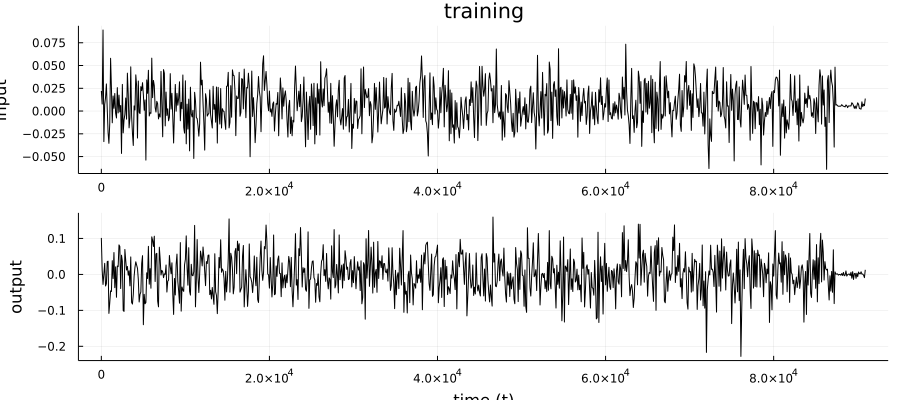

In [8]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signal
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

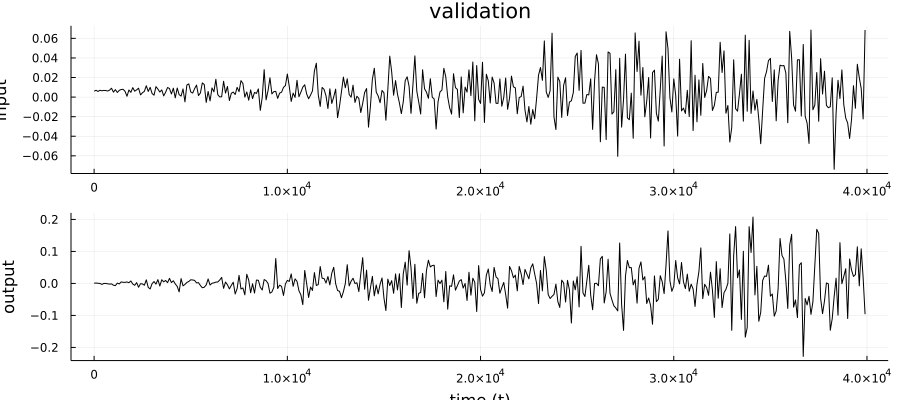

In [9]:
n = 100
ix = 1:n:T_val

# Plot validation signal
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### Model specification

In [10]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [11]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [12]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [13]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [14]:
order_y, order_u, order_h = 2, 2, 3
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [15]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [16]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e12;
    obs_prec = 1e2
    b = ones(order);
    
    params_flow = model_params[1:end-2]
    params_w    = model_params[end-1:end]
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), prec*diageye(h_order)))}
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
#     Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order))
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    θ ~ MvNormalMeanPrecision(zeros(h_order), prec*diageye(h_order))
    
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
#         h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], obs_prec)
        h_prev = h[t]
    end

    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
end

nonlinear_max_mv (generic function with 1 method)

In [17]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    params_w    = params[end-1:end]
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
#     setmessages!(h, MvNormalMeanPrecision(randn(order_h), 1e12*diageye(order_h)))
    
    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [18]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

### Prepare data

In [19]:
# Random.seed!(data_seed)

# n_samples = 1000
# u = 3 .* sin.(collect(1:n_samples+10))
# y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
#                                                      Dict(:er_var=>1e-2, :u=>u));

In [20]:
train_size = 800
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

### Train model

In [21]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; [1.0, 1.0]]

56-element Vector{Float64}:
 -0.3179695928057278
  0.9776221095017685
 -1.302121139959913
 -0.22534055313176568
  2.2260446301077863
  0.9394246742858201
  1.1017041528684897
  0.7890058448820707
 -0.11671547310971386
  2.643745143350261
  0.9916863399279355
 -2.722437547850197
  0.02618265942906552
  ⋮
 -0.4756875171164519
  0.11870407420280213
  1.2450042382811726
 -0.664937325209685
 -0.11004215429814973
  0.09149482121688793
 -0.29811746891356267
  0.10794398075218822
 -1.1870158605317582
  0.14053187196952818
  1.0
  1.0

In [22]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


In [23]:
fe_

10-element Vector{Any}:
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495
 2956.672526315495

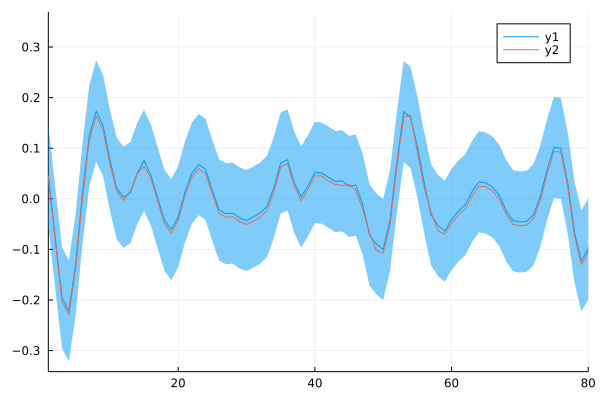

In [24]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [25]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))
plot!(h_gen, xlims=(mfrom, mto))

LoadError: UndefVarError: h_gen not defined

In [26]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=2);
    
    return fe_[end]
end;

In [27]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

LoadError: MethodError: no method matching Float64(::TinyNumber)
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:760
[0m  (::Type{T})([91m::VectorizationBase.Double{T}[39m) where T<:Union{Float16, Float32, Float64, VectorizationBase.Vec{var"#s33", var"#s32"} where {var"#s33", var"#s32"<:Union{Float16, Float32, Float64}}, VectorizationBase.VecUnroll{var"#s31", var"#s30", var"#s29", V} where {var"#s31", var"#s30", var"#s29"<:Union{Float16, Float32, Float64}, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{var"#s30", var"#s29"}}}} at /home/wmkouw/.julia/packages/VectorizationBase/xtnDY/src/special/double.jl:84
[0m  ...

In [28]:
inf_params = Optim.minimizer(res)

LoadError: UndefVarError: res not defined

In [29]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=40);

LoadError: UndefVarError: inf_params not defined

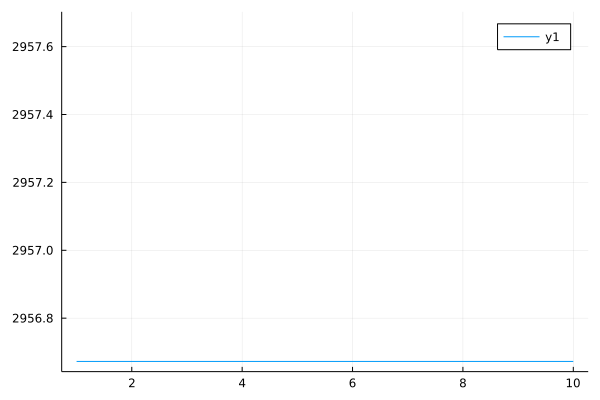

In [30]:
plot(fe_)

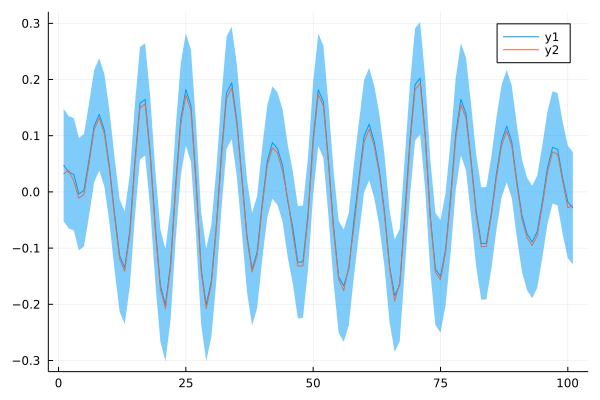

In [31]:
mfrom, mto = 100, 200
plot(mean.(y_out_[mfrom:mto]), ribbon=sqrt.(cov.(y_out_[mfrom:mto])))
plot!(Y_train[mfrom:mto])

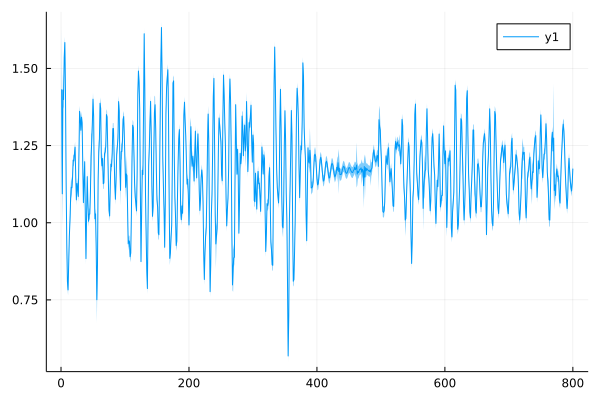

In [32]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [33]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [0.040944888293293576 -0.11617635449440179 0.0551298344182851; -0.11617635449440179 0.3796294279839169 0.04003689392635762; 0.0551298344182851 0.04003689392635762 0.8917849296250105]
 [0.01173463840978361 -0.021458778625738 0.06414297392446638; -0.021458778625738 0.04094488829329447 -0.11617635449440362; 0.06414297392446638 -0.11617635449440362 0.3796294279839242]
 [0.002834578004130507 -0.005474655318871418 0.010096314444631271; -0.005474655318871418 0.011734638409783699 -0.021458778625738167; 0.010096314444631271 -0.021458778625738167 0.04094488829329476]
 [0.0009117560928407521 -0.001339208967882519 0.0026419279958927048; -0.001339208967882519 0.002834578004130475 -0.005474655318871348; 0.0026419279958927048 -0.005474655318871348 0.011734638409783555]
 [0.0004569375378718684 -0.00040277461285904433 0.0006415694687035026; -0.00040277461285904433 0.0009117560928407519 -0.0013392089678825195; 0.0006415694687035026 -0.0013392089678825195 0.002834578

## KF-like prediction

In [34]:
function transition(γ, order)
    V = zeros(order, order)
#     V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [35]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)
    c = zeros(h_order); c[1] = 1.0

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, inf_params[1:end-2])) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2 + dot(h, c), 1e4)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [36]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y_lat_2), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [37]:
mean(h_[end])

3-element Vector{Float64}:
 1.1753575335010953
 1.1295396567990095
 1.1029849838860002

In [38]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = inf_params[end-1:end][1]/inf_params[end-1:end][2]
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);
    h_prev = (mean.(h_inf)[end], precision.(h_inf)[end])
    
end

LoadError: UndefVarError: inf_params not defined

┌ Warning: Keyword argument letter not supported with Plots.GRBackend().  Choose from: Set([:top_margin, :group, :inset_subplots, :background_color, :ytickfontsize, :yforeground_color_text, :yguidefontcolor, :tickfontfamily, :show_empty_bins, :seriesalpha, :seriescolor, :ztick_direction, :xgrid, :ygridalpha, :zlims, :xtick_direction, :colorbar, :legend_font_family, :zflip, :ticks, :linealpha, :overwrite_figure, :arrow, :xguidefonthalign, :normalize, :linestyle, :xtickfontvalign, :xflip, :zgrid, :fillcolor, :ygrid, :bar_width, :colorbar_scale, :background_color_inside, :zguidefonthalign, :bins, :zguide, :zforeground_color_text, :legend_font_valign, :yscale, :legend_font_color, :weights, :xgridalpha, :ygridstyle, :clims, :xtickfontcolor, :fill_z, :xguide, :markershape, :background_color_subplot, :ztickfontfamily, :fillalpha, :markerstrokewidth, :tick_direction, :xguidefontvalign, :xguidefontfamily, :gridlinewidth, :foreground_color_subplot, :xgridlinewidth, :yguidefontsize, :foreground_c

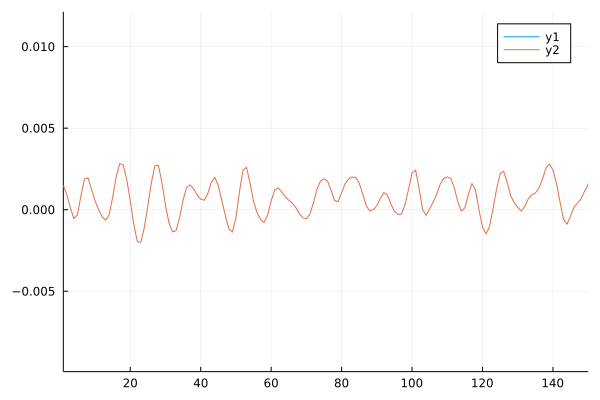

In [39]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))))
plot!(Y_test, xlims=(1, 150))